In [265]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Helper Functions

In [266]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [267]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [268]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [269]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [270]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 0

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 10
noise = 0

if noise:
    if direction:
        temp_train = add_noise(temp_train, noise_scale)
    else:
        spectrum_train = add_noise(spectrum_train, noise_scale)

if not combine:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
    temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [271]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [272]:
n_samples, input_size = X.shape
_, output_size = y.shape

# Design Model 
(input size, output size, forward pass)

In [273]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, output_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = self.lin_fin(output)
        return output

In [274]:
model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [275]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [276]:
loss_list = []
num_epochs = 1000

for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    loss_list.append(loss.item())

    # backward pass
    loss.backward()

    # update
    optimizer.step()

    # empty gradients
    optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 100, loss = 0.0765
epoch: 200, loss = 0.0561
epoch: 300, loss = 0.0430
epoch: 400, loss = 0.0299
epoch: 500, loss = 0.0150
epoch: 600, loss = 0.0092
epoch: 700, loss = 0.0070
epoch: 800, loss = 0.0063
epoch: 900, loss = 0.0060
epoch: 1000, loss = 0.0059


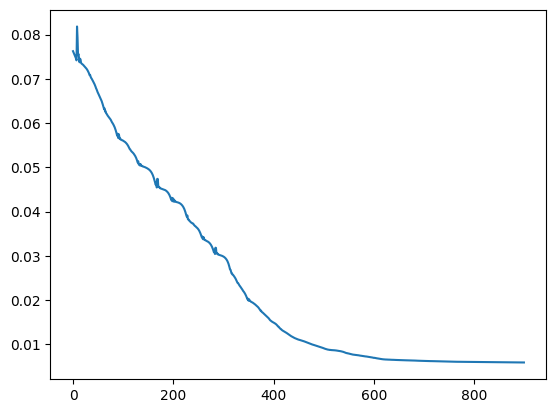

In [277]:
plt.plot(loss_list[100:num_epochs])

# Plots

### Clean

In [278]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [279]:
import matplotlib.pyplot as plt
import random

def plot_actual_vs_pred(index):
    actual_np = actual.values[index]
    pred_np = pred.values[index]


    plt.plot(y_train.columns, actual_np, label='actual')
    plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

    if direction:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

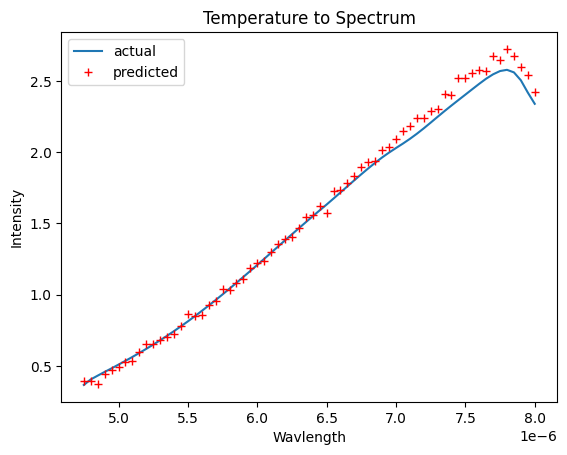

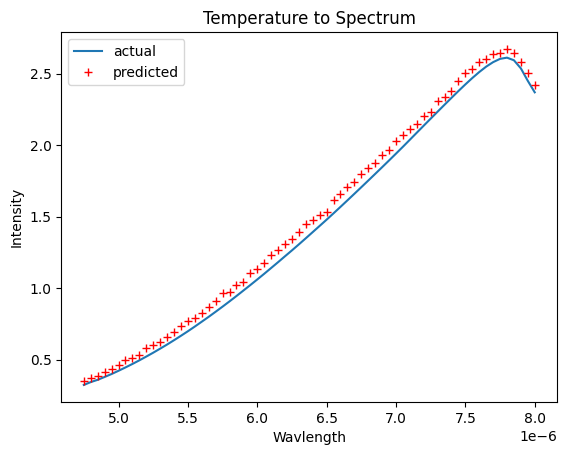

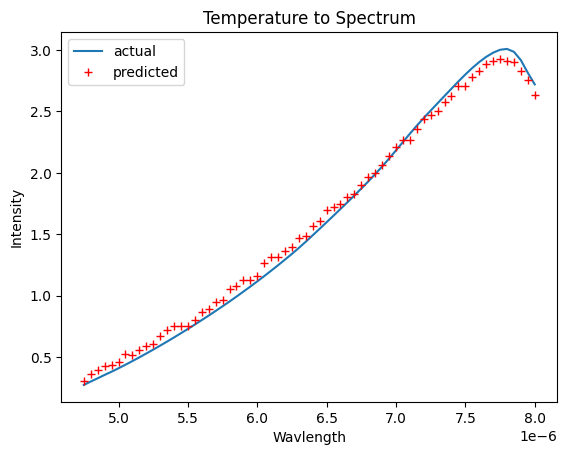

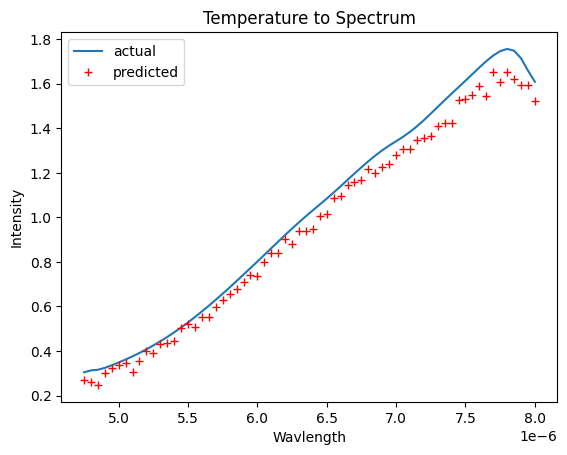

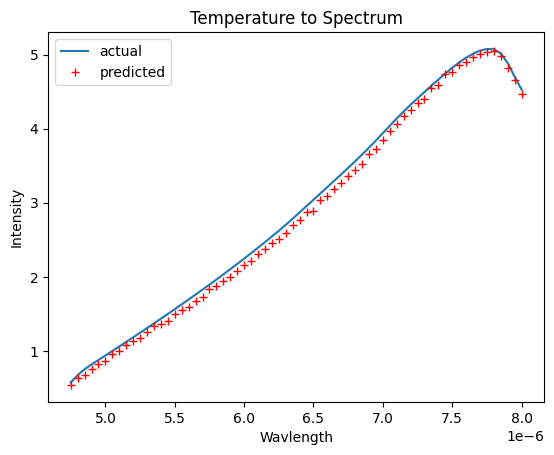

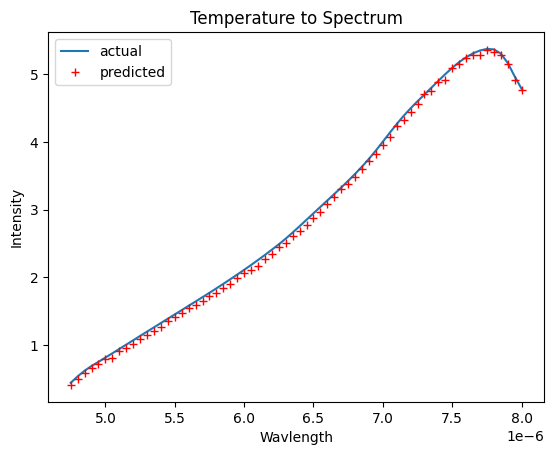

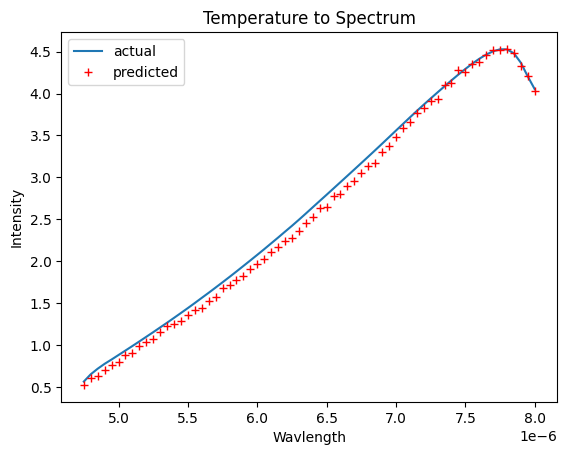

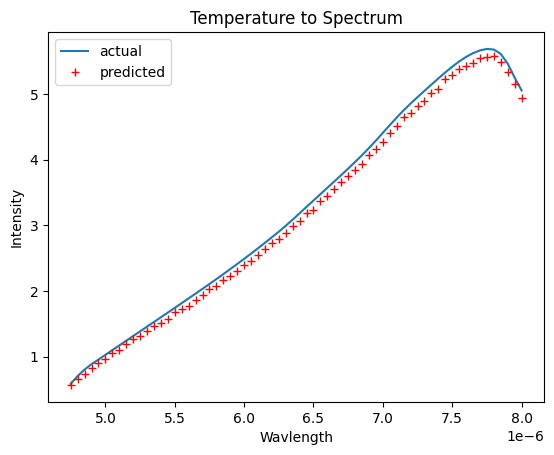

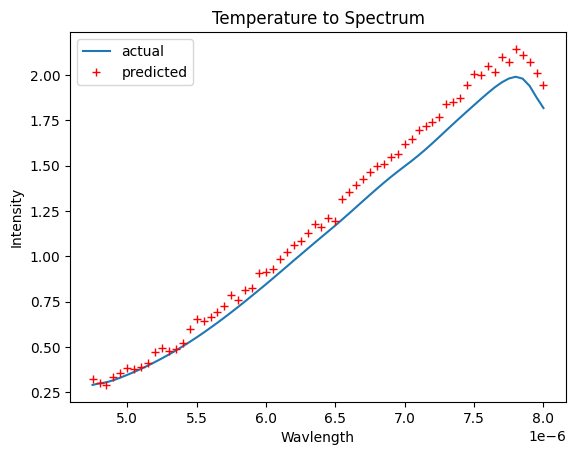

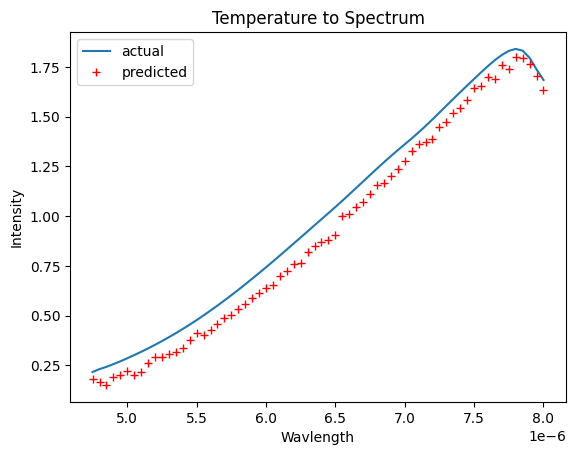

In [280]:
for index in range(10):
    plot_actual_vs_pred(index*10)